# image-captionging_InceptionV3_Transformer
> 작물 질병 진단 서비스 (for crop disease diagnosis service)
* 5 개의 작물(crop) / 8 개의 질병(disease)
* 고추, 애호박, 토마토, 파, 콩
* 탄저병, 흰가루병, 노균병, 녹병, 점무늬병, 검은무늬병, 불마름병, 잎마름병, 

# 라이브러리

In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re


import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

# 데이터 불러오기 및 전처리

In [3]:
image_path = "C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/"
dir_labelling = pd.read_csv(r"C:\Users\DI Lee\Desktop\crop_dataset\train\label\final\crop_captioning_label.csv", encoding='cp949')

In [4]:
dir_labelling.head()

,images,captions
0,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,연녹색의 병반이 잎의 표면에 있는 것을 보아 잎마름병으로 판단됩니다
1,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,병반이 잎의 표면에 있고 점이 연녹색인 것을 보아 잎마름병으로 판단됩니다
2,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,잎의 표면에 연녹색의 병반이 있는 것으로 보아 잎마름병으로 사료됩니다
3,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,연녹색 병반이 잎에 표면에 나 있는 것을 보아 잎마름병으로 판단됩니다
4,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,잎의 표면에 연녹색 병반이 퍼져있는 것으로 보아 잎마름병으로 판단됩니다


In [5]:
ls = os.listdir(image_path)
print(f"total images (총 이미지 개수) : {len([f for f in ls if '.npy' not in f])}") #train 이미지 총 개수

total images (총 이미지 개수) : 114505


In [6]:
print(f"total captions (총 캡션 label 개수) : {len(dir_labelling)}")

total captions (총 캡션 label 개수) : 569365


# 이미지와 캡션 문장 조회
* 4개의 이미지에 대해, 각 이미지에 5개씩 대응되는 캡션 문장 출력

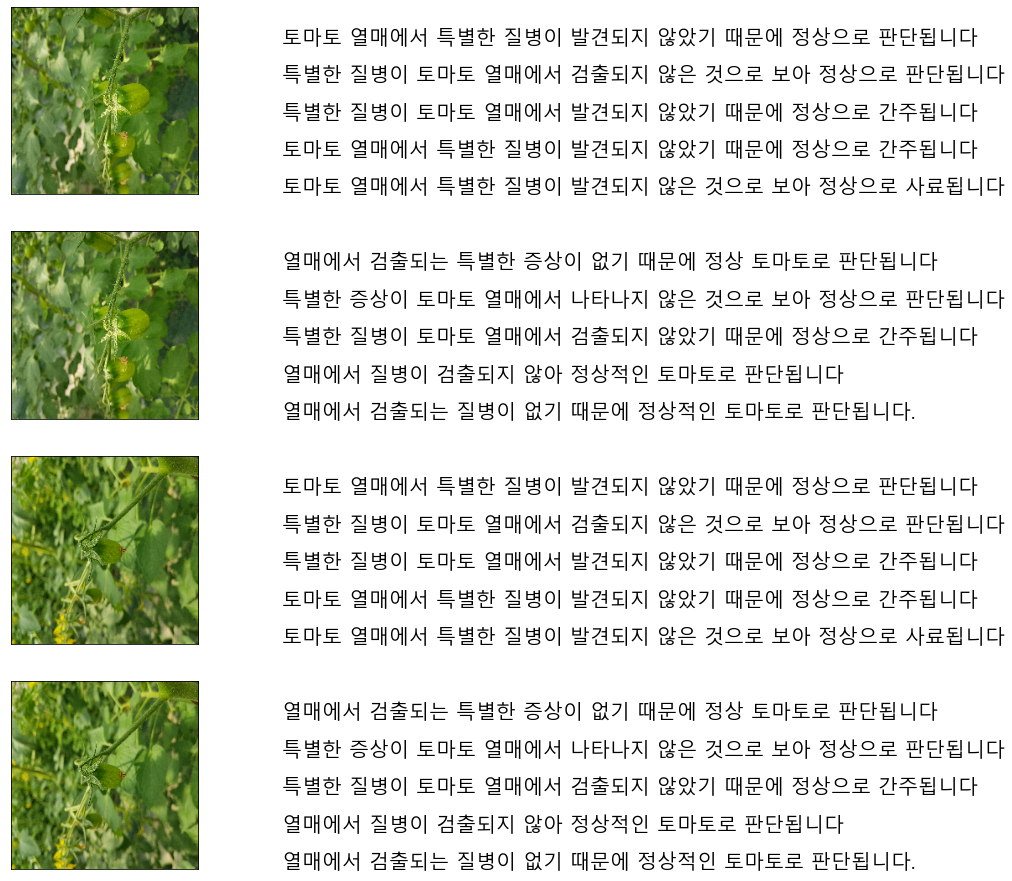

In [7]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in np.unique(dir_labelling['images'])[10:14]:
    filename = image_path + '/' + jpgfnm
    captions = list(dir_labelling["captions"].loc[dir_labelling["images"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

#  `<start>`, `<end>` 토큰 부착하기

In [10]:
attached_captions = []
for caption in dir_labelling['captions']:
    caption = '<start> ' + caption + ' <end>'
    attached_captions.append(caption)

In [11]:
attached_captions[:10]

['<start> 연녹색의 병반이 잎의 표면에 있는 것을 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 병반이 잎의 표면에 있고  점이 연녹색인 것을 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 잎의 표면에 연녹색의 병반이 있는 것으로 보아 잎마름병으로 사료됩니다 <end>',
 '<start> 연녹색 병반이 잎에 표면에 나 있는 것을 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 잎의 표면에 연녹색 병반이 퍼져있는 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 연녹색 점이 잎의 표면에  퍼져있는 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 볼록 튀어나와있는 병반이 연녹색인 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 잎에서 볼록하게 튀어나온 병반이 연녹색인 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 연녹색인 볼록한 병반이 있는 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 볼라관 연녹색의 병반이 있는 것으로 보아 잎마름병으로 판단됩니다 <end>']

# 전체 이미지 경로 리스트
* label 데이터의 이미지 경로를 불러오기 때문에 한 이미지당 5개씩 중복

In [12]:
all_img_name_vector = []
for file in dir_labelling['images']:
    full_img_path = image_path + file
    all_img_name_vector.append(full_img_path)

all_img_name_vector[:10]

['C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0001.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0001.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0001.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0001.jpg',
 'C:/Users

# 전체 이미지 경로와 캡션 개수 조회
* `all_img_name_vector` : 전체 이미지 경로 개수
* `attached_captions` ; 전체 캡션 개수

In [13]:
print(f'all_img_name_vector(전체 이미지 경로 개수) : {len(all_img_name_vector)}\nattached_captions(전체 캡션 개수) : {len(attached_captions)}')

all_img_name_vector(전체 이미지 경로 개수) : 569365
attached_captions(전체 캡션 개수) : 569365


# 이미지 특징 추출 모델 정의
> InceptionV3
* 이미지 캡셔닝 모델의 인코더 부분에서 사용
* (Imagenet에 대해 사전 훈련된) InceptionV3을 사용하여 이미지를 분류하고 마지막 Convolutional Layer에서 특징을 추출
* 이미지 분류를 하지 않으므로 마지막 layer인 softmax 층을 제거
- 이미지를 299px x 299px로 resize합니다.
* 이미지에서 특징만 추출
* 모델 이름: `image_features_extract_model`

In [14]:
#이미지 읽어오는 함수
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') #InceptionV3 이미지 특징 추출
new_input = image_model.input
#이미지 분류를 하지 않으므로 마지막 layer인 softmax 층을 제거함. 즉, 이미지에서 특징만 추출
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)#이미지 특징 추출 모델


In [15]:
#개수가 같은 전체 캡션 개수 배열(array)과 전체 이미지 이름 배열에 대해 일관된 순서로 데이터를 섞는다.
#두 배열에서 같은 행 인덱스에 있던 값은 데이터가 섞인 뒤에도 서로 같은 위치에 있다.
train_captions, img_name_vector = shuffle(attached_captions, all_img_name_vector, random_state=8)

### 이미지를 읽어오는 함수(load_image)에 각 이미지 이름을 대응(map)시킨다.
* `encoded_train` : 이미지들의 경로(중복제거)

In [16]:
encoded_train = sorted(set(img_name_vector)) #집합으로 변환하는 이유: 코드 처리 속도 빠르게 하기 위해서, 중복없는 이미지만 있게 하려고(혹시 모르니까)
image_dataset = tf.data.Dataset.from_tensor_slices(encoded_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [17]:
print(len(image_dataset))

7118


# 이미지 특징 추출 캐싱
* 이미지에서 특징을 추출하고, 각 특징을 넘파이 형식의 파일(.npy)로 변환하여 디스크에 저장
* 이후 이 넘파이 형식의 특징 파일은 인코더에 입력
* 넘파이 형식의 파일은 자료형과 행렬크기정보 등 배열(array)을 재구성하는데 필요한 모든 정보를 저장

In [18]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████████████████████████████████████████████████████████████████████████| 7118/7118 [19:18<00:00,  6.14it/s]


# 캡션 전처리 및 토큰화
- 캡션을 토큰화하여 중복 없는 단어들로 구성된 사전을 구축
- 구두점은 모두 제거
- 사전에 없는 단어가 있을 시, 해당 단어는 `<unk>` 토큰으로 대체
- 각 단어에 인덱스를 부여하고, `단어:인덱스` 형식으로 변형한다.
- 학습을 위해 모든 문장의 길이를 맞춰줘야하기 때문에 모든 문장(시퀀스)을 가장 길이가 긴 문장의 길이에 맞춤
- 길이는 0으로 padding

In [18]:
#토크나이저 생성
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token = '<unk>',
                                                  filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [19]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
print(train_seqs[:10])

[[2, 13, 14, 84, 35, 16, 21, 6, 52, 50, 22, 4, 3], [2, 32, 80, 107, 38, 17, 6, 5, 22, 20, 3], [2, 42, 8, 7, 23, 17, 6, 5, 24, 4, 3], [2, 26, 30, 7, 31, 92, 120, 19, 4, 3], [2, 11, 147, 148, 193, 68, 29, 194, 116, 117, 6, 20, 3], [2, 42, 8, 11, 146, 43, 41, 6, 5, 18, 4, 3], [2, 84, 35, 16, 21, 6, 52, 50, 13, 48, 4, 3], [2, 7, 31, 93, 26, 121, 5, 19, 4, 3], [2, 84, 35, 16, 21, 6, 52, 50, 13, 48, 4, 3], [2, 171, 172, 38, 98, 6, 5, 22, 4, 3]]


In [20]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [21]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '판단됩니다': 4, '보아': 5, '것으로': 6, '검은': 7, '잎에': 8, '애호박': 9, '의심됩니다': 10, '특별한': 11, '때문에': 12, '토마토': 13, '잎에서': 14, '질병이': 15, '반점이': 16, '있는': 17, '정상으로': 18, '파검은무늬병으로': 19, '사료됩니다': 20, '나타나는': 21, '잎마름병으로': 22, '점이': 23, '콩점무늬병으로': 24, '것을': 25, '파': 26, '발견되어': 27, '담황색': 28, '고추에': 29, '줄기에': 30, '포자층이': 31, '잎의': 32, '발견되지': 33, '고추탄저병으로': 34, '노란색': 35, '고추흰가루병으로': 36, '않았기': 37, '병반이': 38, '같은': 39, '반점과': 40, '않은': 41, '콩': 42, '검출되지': 43, '흰가루병으로': 44, '부정형': 45, '증상이': 46, '노균병으로': 47, '잎곰팡이병으로': 48, '나타나고': 49, '때': 50, '간주됩니다': 51, '보았을': 52, '있어': 53, '원형': 54, '말라': 55, '병무늬가': 56, '열매에서': 57, '앞면에': 58, '모양의': 59, '분생포자가': 60, '서릿발': 61, '이슬과': 62, '포자와': 63, '비틀어진': 64, '연한': 65, '흰색': 66, '엷은': 67, '않아': 68, '정상적인': 69, '포자가': 70, '생각됩니다': 71, '황갈색의': 72, '황갈색': 73, '곰팡이가': 74, '검출되는': 75, '없기': 76, '포자층을': 77, '황색을': 78, '있기': 79, '표면에': 80, '반점무늬가': 81, '포자덩어리와': 82, '움푹': 83, '분생포자와': 84, '보니': 85, '들어간': 86, '정상': 87, '나타나지'

In [22]:
print(tokenizer.index_word)

{1: '<unk>', 2: '<start>', 3: '<end>', 4: '판단됩니다', 5: '보아', 6: '것으로', 7: '검은', 8: '잎에', 9: '애호박', 10: '의심됩니다', 11: '특별한', 12: '때문에', 13: '토마토', 14: '잎에서', 15: '질병이', 16: '반점이', 17: '있는', 18: '정상으로', 19: '파검은무늬병으로', 20: '사료됩니다', 21: '나타나는', 22: '잎마름병으로', 23: '점이', 24: '콩점무늬병으로', 25: '것을', 26: '파', 27: '발견되어', 28: '담황색', 29: '고추에', 30: '줄기에', 31: '포자층이', 32: '잎의', 33: '발견되지', 34: '고추탄저병으로', 35: '노란색', 36: '고추흰가루병으로', 37: '않았기', 38: '병반이', 39: '같은', 40: '반점과', 41: '않은', 42: '콩', 43: '검출되지', 44: '흰가루병으로', 45: '부정형', 46: '증상이', 47: '노균병으로', 48: '잎곰팡이병으로', 49: '나타나고', 50: '때', 51: '간주됩니다', 52: '보았을', 53: '있어', 54: '원형', 55: '말라', 56: '병무늬가', 57: '열매에서', 58: '앞면에', 59: '모양의', 60: '분생포자가', 61: '서릿발', 62: '이슬과', 63: '포자와', 64: '비틀어진', 65: '연한', 66: '흰색', 67: '엷은', 68: '않아', 69: '정상적인', 70: '포자가', 71: '생각됩니다', 72: '황갈색의', 73: '황갈색', 74: '곰팡이가', 75: '검출되는', 76: '없기', 77: '포자층을', 78: '황색을', 79: '있기', 80: '표면에', 81: '반점무늬가', 82: '포자덩어리와', 83: '움푹', 84: '분생포자와', 85: '보니', 86: '들어간', 87: '정상', 88: '나

In [23]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector =  tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [24]:
cap_vector[:5]

array([[  2,  13,  14,  84,  35,  16,  21,   6,  52,  50,  22,   4,   3,
          0,   0,   0,   0],
       [  2,  32,  80, 107,  38,  17,   6,   5,  22,  20,   3,   0,   0,
          0,   0,   0,   0],
       [  2,  42,   8,   7,  23,  17,   6,   5,  24,   4,   3,   0,   0,
          0,   0,   0,   0],
       [  2,  26,  30,   7,  31,  92, 120,  19,   4,   3,   0,   0,   0,
          0,   0,   0,   0],
       [  2,  11, 147, 148, 193,  68,  29, 194, 116, 117,   6,  20,   3,
          0,   0,   0,   0]])

In [25]:
cap_vector.shape

(569365, 17)

# 모델 훈련을 위한 tensorflow 의 data.dataset을 생성 
* `(tf.data.dataset)`

In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_vector) // BATCH_SIZE

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode("utf-8")+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_vector, cap_vector))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 모델 생성 
- CNN에서는 이미지의 Feature들을 추출해낸 후, 
- 추출한 Feature들을 RNN을 통해서 단어 토큰으로 출력하는 구조로 이루어집니다. 

### positional encoding 
- 입력 토큰의 문장에서의 위치 정보를 알려줌
- 입력 벡터의 인덱스가 홀수면 코사인함수를 이용하여 위치 벡터를 생성하고, 입력 벡터의 인덱스가 짝수면 사인함수를 이용하여 위치 벡터를 생성함.
- 그 다음 각 위치 벡터를 해당 벡터에 대응되는 입력 벡터에 더함.

In [27]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)
    #짝수 인덱스에는 사인함수를 적용 
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    #홀수 인덱스에는 코사인 함수를 적용
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
    assert d_model % 2 == 0

    # 첫번째 d_model/2는 행 임베딩을 인코딩하고 두번째 d_model/2는 열 임베딩을 인코딩한다.
    row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

    angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

    # apply sin and cos to odd and even indices resp.
    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
    pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

### Multi-Head Attention
- self attention 층을 여러 겹 쌓은 것
- query(q), key(k), value(v) 벡터를 생성
    - k와 v의 길이는 같아야 한다. 
    - 이후 어텐션 스코어를 구할 때 두 벡터를 내적하여 하나의 스칼라 값을 구함.


In [28]:
#패드 토큰 마스킹하기 - 패딩한 토큰을 모델이 입력으로 취급하지 않도록 한다.
#위에서 0으로 패딩된 패드 토큰은 1을 출력하고 나머지 토큰은 0을 출력하도록 함수를 생성함.
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

#look ahead mask를 생성. look ahead mask는 모델의 학습을 위해 전체 시퀀스에서 현재 예측해야 하는 시퀀스부터 미래에 예측해야 하는 시퀀스까지 모두 마스킹하는 것.
#예를 들어 세 번째 토큰을 예측하기 위해 첫번째, 두번째 토큰만 사용하고 세번째 토큰부터는 마스킹하는 것.
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#query, key, value로 attention weight를 계산하는데, query와 key를 내적하여 나온 스칼라 값(attention score)에 key의 차원 수(dk)의 제곱근을 나눠주어 스칼라값을 스케일링 해준다.
#스케일링 하는 이유: key의 차원이 커질수록 query와 key에 대한 내적 계산시 내적된 값이 커지는 문제를 보완하기 위해 수행.
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  #마스킹되는 위치에 절댓값이 매우 작은 음수 값을 넣는다(-0.000000001)
  #나중에 소프트맥스 함수를 거치면 이 마스킹된 위치의 값은 거의 0으로 수렴한다.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [29]:
#Multi-Head Attention : 어텐션을 여러번 병렬로 처리한다.
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights


### Point-Wise Feed Forward Neural Network

- 두 개의 완전 연결된 층(layer)으로 구성된 네트워크로, 활성화 함수로는 ReLU함수를 사용
- 트랜스포머 모델에서의 인코더 구조, 디코더 구조 모두에 공통적으로 사용

In [30]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model) #(batch_size, seq_len, d_model)
                ])

### 모델의 인코더 구조 정의

In [31]:
#인코더 층(layer)을 정의하기
  #<구성 요소>
  # 패딩 마스크가 포함된 Multi-Head Attention
  # Point-Wise Feed Forward Neural Network

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        #층 정규화(layer normalization)
        #모델 학습을 돕기 위해 텐서의 마지막 차원에 대한 평균과 분산을 구하고 평균, 분산값을 이용한 수식으로 값을 정규화하는 과정
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        #드롭아웃(Drop Out)
        #과대적합(Overfitting)을 방지하기 위해 rate의 확률로 뉴런을 제거하는 기법
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)


    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        #잔차 연결(x + attn_output) -> 그래디언트 소멸 문제를 피하는데 도움을 준다.
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        #잔차 연결(out1 + ffn_output) -> 그래디언트 소멸 문제를 피하는데 도움을 준다.
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

In [32]:
#인코더 구조를 정의하기
  #<구성 요소>
  # 입력 임베딩 벡터
  # 위치 인코딩
  # N개의 인코더 층

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
        self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                          for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

### 모델의 디코더 구조 정의

In [33]:
#디코더 층(layer)을 정의하기
  #<구성 요소>
  # look-ahead 마스크와 패딩 마스크가 포함된 Masked Multi-Head Attention
  # 패딩 마스크가 포함된 Multi-Head Attention. Key, Value는 인코더의 결과물을 입력값으로 받고, Query는 Masked Multi-Head Attention 층의 결과물을 입력값으로 받는다.
  # Point-Wise Feed Forward Neural Network

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None): # enc_output.shape == (batch_size, input_seq_len, d_model)
      
        # self-attention 진행 중에 현재의 query가 미래의 token을 고려하지 않도록 하기 위해 look-ahead mask를 사용함
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # 인코더 출력값의 패딩된 값과 디코더 입력값의 패딩된 값을 피하기 위해 padding mask를 사용한다
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [34]:
#디코더 구조를 정의하기
  #<구성 요소>
  # 출력 임베딩 벡터
  # 위치 인코딩
  # N개의 디코더 층

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
      
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

# 트랜스포머 모델 생성
- 인코더 구조, 디코더 구조, 마지막 선형 층으로 구성
- 디코더의 출력 결과는 선형 층의 입력값으로 들어가서, 생성된 최종 결과물이 반환

In [35]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                      target_vocab_size,max_pos_encoding, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
        dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

## 트랜스포머 모델 훈련을 위한 매개변수(Hyperparameters) 설정

In [37]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
#오버피팅 방지
dropout_rate = 0.2

### 커스터마이징한 학습률 스케줄러 생성
* 학습률 스케줄러의 역할: 모델 학습과정에서 미리 학습 일정을 정해두고 그 일정에 따라 학습률을 동적으로 변경
* Attention is all you need' 논문 즉, Transformer 모델을 소개한 이 논문에서 사용한 학습률 스케줄러를 생성

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 학습률, 옵티마이저, 손실함수 정의하기

In [39]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
   
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

# transformer 모델 생성 및 정의

In [40]:
#훈련 오차 및 정확도 선언
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

#트랜스포머
transformer = Transformer(num_layer,
                          d_model,
                          num_heads,
                          dff,
                          row_size,
                          col_size,
                          target_vocab_size, 
                          max_pos_encoding=target_vocab_size,
                          rate=dropout_rate)

In [41]:
print(transformer)

# 모델 체크포인트

In [42]:
checkpoint_path = "C:/Users/DI Lee/Desktop/weight/checkpoints_transformer/"
checkpoint = tf.train.Checkpoint(optimizer = optimizer, model = transformer)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep = 5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    #checkpoint_path에 가장 최신의 체크포인트를 저장한다
    ckpt.restore(ckpt_manager, latest_checkpoint)

# 모델 훈련
- 이미지에서 추출된 특징이 담겨있는 .npy 파일과 정답 라벨 문장(타겟 문장)을 트랜스포머 모델에 입력하면 그 이미지에 대한 예상 문장(캡션)을 출력
- 결과에 대한 loss 및 gradient 계산 후 loss가 최소가 되도록 훈련을 반복

In [43]:
def create_masks_decoder(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return combined_mask

In [44]:
@tf.function
def train_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    dec_mask = create_masks_decoder(tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
for epoch in tqdm(range(30)):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (img_tensor, tar)) in enumerate(dataset):
        train_step(img_tensor, tar)
      
        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    
    if epoch % 5 == 0:
        ckpt_manager.save()

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 9.2839 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8924 Accuracy 0.0319
Epoch 1 Batch 100 Loss 8.4675 Accuracy 0.0471
Epoch 1 Batch 150 Loss 8.0598 Accuracy 0.0523
Epoch 1 Batch 200 Loss 7.5478 Accuracy 0.0615
Epoch 1 Batch 250 Loss 6.9772 Accuracy 0.0827
Epoch 1 Batch 300 Loss 6.4147 Accuracy 0.1143
Epoch 1 Batch 350 Loss 5.8920 Accuracy 0.1489
Epoch 1 Batch 400 Loss 5.4139 Accuracy 0.1821
Epoch 1 Batch 450 Loss 4.9851 Accuracy 0.2135
Epoch 1 Batch 500 Loss 4.6021 Accuracy 0.2420
Epoch 1 Batch 550 Loss 4.2660 Accuracy 0.2673
Epoch 1 Batch 600 Loss 3.9720 Accuracy 0.2898
Epoch 1 Batch 650 Loss 3.7142 Accuracy 0.3094
Epoch 1 Batch 700 Loss 3.4879 Accuracy 0.3267
Epoch 1 Batch 750 Loss 3.2881 Accuracy 0.3421
Epoch 1 Batch 800 Loss 3.1105 Accuracy 0.3556
Epoch 1 Batch 850 Loss 2.9523 Accuracy 0.3677
Epoch 1 Batch 900 Loss 2.8107 Accuracy 0.3784
Epoch 1 Batch 950 Loss 2.6833 Accuracy 0.3881
Epoch 1 Batch 1000 Loss 2.5681 Accuracy 0.3971
Epoch 1 Batch 1050 Loss 2.4632 Accur

Epoch 1 Batch 8750 Loss 0.5816 Accuracy 0.5489
Epoch 1 Batch 8800 Loss 0.5800 Accuracy 0.5490
Epoch 1 Batch 8850 Loss 0.5784 Accuracy 0.5491


  3%|██▋                                                                            | 1/30 [20:28<9:53:39, 1228.25s/it]

Epoch 1 Loss 0.5769 Accuracy 0.5493
Time taken for 1 epoch: 1228.2507801055908 secs

Epoch 2 Batch 0 Loss 0.3224 Accuracy 0.5400
Epoch 2 Batch 50 Loss 0.3050 Accuracy 0.5705
Epoch 2 Batch 100 Loss 0.2993 Accuracy 0.5717
Epoch 2 Batch 150 Loss 0.2965 Accuracy 0.5725
Epoch 2 Batch 200 Loss 0.2963 Accuracy 0.5722
Epoch 2 Batch 250 Loss 0.2955 Accuracy 0.5728
Epoch 2 Batch 300 Loss 0.2956 Accuracy 0.5726
Epoch 2 Batch 350 Loss 0.2951 Accuracy 0.5724
Epoch 2 Batch 400 Loss 0.2946 Accuracy 0.5722
Epoch 2 Batch 450 Loss 0.2944 Accuracy 0.5727
Epoch 2 Batch 500 Loss 0.2946 Accuracy 0.5727
Epoch 2 Batch 550 Loss 0.2950 Accuracy 0.5727
Epoch 2 Batch 600 Loss 0.2950 Accuracy 0.5728
Epoch 2 Batch 650 Loss 0.2947 Accuracy 0.5730
Epoch 2 Batch 700 Loss 0.2947 Accuracy 0.5732
Epoch 2 Batch 750 Loss 0.2944 Accuracy 0.5732
Epoch 2 Batch 800 Loss 0.2942 Accuracy 0.5730
Epoch 2 Batch 850 Loss 0.2941 Accuracy 0.5730
Epoch 2 Batch 900 Loss 0.2940 Accuracy 0.5729
Epoch 2 Batch 950 Loss 0.2939 Accuracy 0.572

Epoch 2 Batch 8650 Loss 0.2855 Accuracy 0.5735
Epoch 2 Batch 8700 Loss 0.2855 Accuracy 0.5735
Epoch 2 Batch 8750 Loss 0.2854 Accuracy 0.5736
Epoch 2 Batch 8800 Loss 0.2854 Accuracy 0.5736
Epoch 2 Batch 8850 Loss 0.2853 Accuracy 0.5736


  7%|█████▎                                                                         | 2/30 [40:48<9:30:56, 1223.45s/it]

Epoch 2 Loss 0.2853 Accuracy 0.5736
Time taken for 1 epoch: 1220.0906658172607 secs

Epoch 3 Batch 0 Loss 0.2841 Accuracy 0.5801
Epoch 3 Batch 50 Loss 0.2798 Accuracy 0.5730
Epoch 3 Batch 100 Loss 0.2762 Accuracy 0.5749
Epoch 3 Batch 150 Loss 0.2750 Accuracy 0.5760
Epoch 3 Batch 200 Loss 0.2751 Accuracy 0.5752
Epoch 3 Batch 250 Loss 0.2750 Accuracy 0.5754
Epoch 3 Batch 300 Loss 0.2747 Accuracy 0.5754
Epoch 3 Batch 350 Loss 0.2750 Accuracy 0.5753
Epoch 3 Batch 400 Loss 0.2753 Accuracy 0.5751
Epoch 3 Batch 450 Loss 0.2757 Accuracy 0.5752
Epoch 3 Batch 500 Loss 0.2756 Accuracy 0.5755
Epoch 3 Batch 550 Loss 0.2755 Accuracy 0.5755
Epoch 3 Batch 600 Loss 0.2754 Accuracy 0.5757
Epoch 3 Batch 650 Loss 0.2751 Accuracy 0.5759
Epoch 3 Batch 700 Loss 0.2751 Accuracy 0.5759
Epoch 3 Batch 750 Loss 0.2750 Accuracy 0.5760
Epoch 3 Batch 800 Loss 0.2750 Accuracy 0.5758
Epoch 3 Batch 850 Loss 0.2752 Accuracy 0.5758
Epoch 3 Batch 900 Loss 0.2752 Accuracy 0.5756
Epoch 3 Batch 950 Loss 0.2753 Accuracy 0.575

Epoch 3 Batch 8650 Loss 0.2708 Accuracy 0.5756
Epoch 3 Batch 8700 Loss 0.2708 Accuracy 0.5756
Epoch 3 Batch 8750 Loss 0.2708 Accuracy 0.5756
Epoch 3 Batch 8800 Loss 0.2708 Accuracy 0.5757
Epoch 3 Batch 8850 Loss 0.2707 Accuracy 0.5757


 10%|███████▋                                                                     | 3/30 [1:01:13<9:10:53, 1224.21s/it]

Epoch 3 Loss 0.2707 Accuracy 0.5757
Time taken for 1 epoch: 1225.1181826591492 secs

Epoch 4 Batch 0 Loss 0.2630 Accuracy 0.5605
Epoch 4 Batch 50 Loss 0.2710 Accuracy 0.5738
Epoch 4 Batch 100 Loss 0.2697 Accuracy 0.5744
Epoch 4 Batch 150 Loss 0.2689 Accuracy 0.5765
Epoch 4 Batch 200 Loss 0.2681 Accuracy 0.5761
Epoch 4 Batch 250 Loss 0.2675 Accuracy 0.5759
Epoch 4 Batch 300 Loss 0.2672 Accuracy 0.5757
Epoch 4 Batch 350 Loss 0.2670 Accuracy 0.5763
Epoch 4 Batch 400 Loss 0.2673 Accuracy 0.5759
Epoch 4 Batch 450 Loss 0.2672 Accuracy 0.5760
Epoch 4 Batch 500 Loss 0.2673 Accuracy 0.5761
Epoch 4 Batch 550 Loss 0.2673 Accuracy 0.5765
Epoch 4 Batch 600 Loss 0.2674 Accuracy 0.5768
Epoch 4 Batch 650 Loss 0.2674 Accuracy 0.5766
Epoch 4 Batch 700 Loss 0.2673 Accuracy 0.5767
Epoch 4 Batch 750 Loss 0.2670 Accuracy 0.5768
Epoch 4 Batch 800 Loss 0.2670 Accuracy 0.5767
Epoch 4 Batch 850 Loss 0.2670 Accuracy 0.5766
Epoch 4 Batch 900 Loss 0.2671 Accuracy 0.5764
Epoch 4 Batch 950 Loss 0.2670 Accuracy 0.576

Epoch 4 Batch 8650 Loss 0.2646 Accuracy 0.5764
Epoch 4 Batch 8700 Loss 0.2646 Accuracy 0.5764
Epoch 4 Batch 8750 Loss 0.2646 Accuracy 0.5764
Epoch 4 Batch 8800 Loss 0.2645 Accuracy 0.5764
Epoch 4 Batch 8850 Loss 0.2645 Accuracy 0.5764


 13%|██████████▎                                                                  | 4/30 [1:21:45<8:51:47, 1227.20s/it]

Epoch 4 Loss 0.2645 Accuracy 0.5764
Time taken for 1 epoch: 1231.7719881534576 secs

Epoch 5 Batch 0 Loss 0.2512 Accuracy 0.5869
Epoch 5 Batch 50 Loss 0.2652 Accuracy 0.5758
Epoch 5 Batch 100 Loss 0.2637 Accuracy 0.5762
Epoch 5 Batch 150 Loss 0.2623 Accuracy 0.5776
Epoch 5 Batch 200 Loss 0.2630 Accuracy 0.5765
Epoch 5 Batch 250 Loss 0.2624 Accuracy 0.5767
Epoch 5 Batch 300 Loss 0.2624 Accuracy 0.5766
Epoch 5 Batch 350 Loss 0.2622 Accuracy 0.5766
Epoch 5 Batch 400 Loss 0.2622 Accuracy 0.5767
Epoch 5 Batch 450 Loss 0.2619 Accuracy 0.5770
Epoch 5 Batch 500 Loss 0.2621 Accuracy 0.5773
Epoch 5 Batch 550 Loss 0.2622 Accuracy 0.5774
Epoch 5 Batch 600 Loss 0.2621 Accuracy 0.5776
Epoch 5 Batch 650 Loss 0.2620 Accuracy 0.5777
Epoch 5 Batch 700 Loss 0.2619 Accuracy 0.5777
Epoch 5 Batch 750 Loss 0.2617 Accuracy 0.5778
Epoch 5 Batch 800 Loss 0.2614 Accuracy 0.5776
Epoch 5 Batch 850 Loss 0.2615 Accuracy 0.5775
Epoch 5 Batch 900 Loss 0.2614 Accuracy 0.5775
Epoch 5 Batch 950 Loss 0.2614 Accuracy 0.577

Epoch 5 Batch 8650 Loss 0.2600 Accuracy 0.5771
Epoch 5 Batch 8700 Loss 0.2599 Accuracy 0.5771
Epoch 5 Batch 8750 Loss 0.2599 Accuracy 0.5771
Epoch 5 Batch 8800 Loss 0.2599 Accuracy 0.5771
Epoch 5 Batch 8850 Loss 0.2599 Accuracy 0.5771


 17%|████████████▊                                                                | 5/30 [1:42:16<8:31:58, 1228.75s/it]

Epoch 5 Loss 0.2599 Accuracy 0.5771
Time taken for 1 epoch: 1231.5126819610596 secs

Epoch 6 Batch 0 Loss 0.2777 Accuracy 0.5918
Epoch 6 Batch 50 Loss 0.2609 Accuracy 0.5746
Epoch 6 Batch 100 Loss 0.2593 Accuracy 0.5767
Epoch 6 Batch 150 Loss 0.2574 Accuracy 0.5779
Epoch 6 Batch 200 Loss 0.2577 Accuracy 0.5771
Epoch 6 Batch 250 Loss 0.2570 Accuracy 0.5771
Epoch 6 Batch 300 Loss 0.2568 Accuracy 0.5774
Epoch 6 Batch 350 Loss 0.2568 Accuracy 0.5776
Epoch 6 Batch 400 Loss 0.2570 Accuracy 0.5775
Epoch 6 Batch 450 Loss 0.2569 Accuracy 0.5777
Epoch 6 Batch 500 Loss 0.2570 Accuracy 0.5777
Epoch 6 Batch 550 Loss 0.2571 Accuracy 0.5779
Epoch 6 Batch 600 Loss 0.2571 Accuracy 0.5781
Epoch 6 Batch 650 Loss 0.2570 Accuracy 0.5780
Epoch 6 Batch 700 Loss 0.2569 Accuracy 0.5783
Epoch 6 Batch 750 Loss 0.2569 Accuracy 0.5782
Epoch 6 Batch 800 Loss 0.2567 Accuracy 0.5781
Epoch 6 Batch 850 Loss 0.2567 Accuracy 0.5781
Epoch 6 Batch 900 Loss 0.2566 Accuracy 0.5779
Epoch 6 Batch 950 Loss 0.2568 Accuracy 0.577

Epoch 6 Batch 8650 Loss 0.2562 Accuracy 0.5776
Epoch 6 Batch 8700 Loss 0.2562 Accuracy 0.5776
Epoch 6 Batch 8750 Loss 0.2562 Accuracy 0.5776
Epoch 6 Batch 8800 Loss 0.2561 Accuracy 0.5776
Epoch 6 Batch 8850 Loss 0.2561 Accuracy 0.5776


 20%|███████████████▍                                                             | 6/30 [2:02:37<8:10:28, 1226.19s/it]

Epoch 6 Loss 0.2561 Accuracy 0.5777
Time taken for 1 epoch: 1221.2076303958893 secs

Epoch 7 Batch 0 Loss 0.2519 Accuracy 0.5674
Epoch 7 Batch 50 Loss 0.2548 Accuracy 0.5764
Epoch 7 Batch 100 Loss 0.2550 Accuracy 0.5780
Epoch 7 Batch 150 Loss 0.2541 Accuracy 0.5786
Epoch 7 Batch 200 Loss 0.2541 Accuracy 0.5776
Epoch 7 Batch 250 Loss 0.2537 Accuracy 0.5782
Epoch 7 Batch 300 Loss 0.2538 Accuracy 0.5780
Epoch 7 Batch 350 Loss 0.2537 Accuracy 0.5780
Epoch 7 Batch 400 Loss 0.2538 Accuracy 0.5777
Epoch 7 Batch 450 Loss 0.2535 Accuracy 0.5780
Epoch 7 Batch 500 Loss 0.2536 Accuracy 0.5782
Epoch 7 Batch 550 Loss 0.2537 Accuracy 0.5781
Epoch 7 Batch 600 Loss 0.2538 Accuracy 0.5784
Epoch 7 Batch 650 Loss 0.2536 Accuracy 0.5785
Epoch 7 Batch 700 Loss 0.2537 Accuracy 0.5786
Epoch 7 Batch 750 Loss 0.2535 Accuracy 0.5787
Epoch 7 Batch 800 Loss 0.2534 Accuracy 0.5786
Epoch 7 Batch 850 Loss 0.2535 Accuracy 0.5783
Epoch 7 Batch 900 Loss 0.2535 Accuracy 0.5783
Epoch 7 Batch 950 Loss 0.2535 Accuracy 0.578

Epoch 7 Batch 8650 Loss 0.2526 Accuracy 0.5781
Epoch 7 Batch 8700 Loss 0.2526 Accuracy 0.5781
Epoch 7 Batch 8750 Loss 0.2526 Accuracy 0.5781
Epoch 7 Batch 8800 Loss 0.2526 Accuracy 0.5781
Epoch 7 Batch 8850 Loss 0.2525 Accuracy 0.5781


 23%|█████████████████▉                                                           | 7/30 [2:22:55<7:48:57, 1223.36s/it]

Epoch 7 Loss 0.2525 Accuracy 0.5781
Time taken for 1 epoch: 1217.5496006011963 secs

Epoch 8 Batch 0 Loss 0.2526 Accuracy 0.5684
Epoch 8 Batch 50 Loss 0.2520 Accuracy 0.5778
Epoch 8 Batch 100 Loss 0.2520 Accuracy 0.5772
Epoch 8 Batch 150 Loss 0.2510 Accuracy 0.5784
Epoch 8 Batch 200 Loss 0.2511 Accuracy 0.5782
Epoch 8 Batch 250 Loss 0.2506 Accuracy 0.5783
Epoch 8 Batch 300 Loss 0.2505 Accuracy 0.5783
Epoch 8 Batch 350 Loss 0.2505 Accuracy 0.5784
Epoch 8 Batch 400 Loss 0.2503 Accuracy 0.5783
Epoch 8 Batch 450 Loss 0.2502 Accuracy 0.5788
Epoch 8 Batch 500 Loss 0.2503 Accuracy 0.5789
Epoch 8 Batch 550 Loss 0.2504 Accuracy 0.5789
Epoch 8 Batch 600 Loss 0.2505 Accuracy 0.5791
Epoch 8 Batch 650 Loss 0.2506 Accuracy 0.5790
Epoch 8 Batch 700 Loss 0.2507 Accuracy 0.5790
Epoch 8 Batch 750 Loss 0.2506 Accuracy 0.5791
Epoch 8 Batch 800 Loss 0.2506 Accuracy 0.5789
Epoch 8 Batch 850 Loss 0.2506 Accuracy 0.5790
Epoch 8 Batch 900 Loss 0.2506 Accuracy 0.5788
Epoch 8 Batch 950 Loss 0.2506 Accuracy 0.578

Epoch 8 Batch 8650 Loss 0.2499 Accuracy 0.5786
Epoch 8 Batch 8700 Loss 0.2499 Accuracy 0.5786
Epoch 8 Batch 8750 Loss 0.2499 Accuracy 0.5786
Epoch 8 Batch 8800 Loss 0.2499 Accuracy 0.5786
Epoch 8 Batch 8850 Loss 0.2499 Accuracy 0.5786


 27%|████████████████████▌                                                        | 8/30 [2:43:14<7:27:59, 1221.82s/it]

Epoch 8 Loss 0.2499 Accuracy 0.5786
Time taken for 1 epoch: 1218.5035490989685 secs

Epoch 9 Batch 0 Loss 0.2480 Accuracy 0.5928
Epoch 9 Batch 50 Loss 0.2497 Accuracy 0.5768
Epoch 9 Batch 100 Loss 0.2492 Accuracy 0.5784
Epoch 9 Batch 150 Loss 0.2476 Accuracy 0.5797
Epoch 9 Batch 200 Loss 0.2479 Accuracy 0.5789
Epoch 9 Batch 250 Loss 0.2475 Accuracy 0.5791
Epoch 9 Batch 300 Loss 0.2474 Accuracy 0.5791
Epoch 9 Batch 350 Loss 0.2475 Accuracy 0.5792
Epoch 9 Batch 400 Loss 0.2477 Accuracy 0.5789
Epoch 9 Batch 450 Loss 0.2474 Accuracy 0.5791
Epoch 9 Batch 500 Loss 0.2475 Accuracy 0.5792
Epoch 9 Batch 550 Loss 0.2477 Accuracy 0.5794
Epoch 9 Batch 600 Loss 0.2477 Accuracy 0.5794
Epoch 9 Batch 650 Loss 0.2478 Accuracy 0.5795
Epoch 9 Batch 700 Loss 0.2478 Accuracy 0.5796
Epoch 9 Batch 750 Loss 0.2478 Accuracy 0.5796
Epoch 9 Batch 800 Loss 0.2478 Accuracy 0.5794
Epoch 9 Batch 850 Loss 0.2478 Accuracy 0.5794
Epoch 9 Batch 900 Loss 0.2479 Accuracy 0.5793
Epoch 9 Batch 950 Loss 0.2481 Accuracy 0.579

Epoch 9 Batch 8650 Loss 0.2476 Accuracy 0.5789
Epoch 9 Batch 8700 Loss 0.2476 Accuracy 0.5789
Epoch 9 Batch 8750 Loss 0.2476 Accuracy 0.5789
Epoch 9 Batch 8800 Loss 0.2476 Accuracy 0.5789
Epoch 9 Batch 8850 Loss 0.2476 Accuracy 0.5789


 30%|███████████████████████                                                      | 9/30 [3:03:33<7:07:24, 1221.16s/it]

Epoch 9 Loss 0.2476 Accuracy 0.5789
Time taken for 1 epoch: 1219.7051184177399 secs

Epoch 10 Batch 0 Loss 0.2434 Accuracy 0.5947
Epoch 10 Batch 50 Loss 0.2488 Accuracy 0.5786
Epoch 10 Batch 100 Loss 0.2501 Accuracy 0.5781
Epoch 10 Batch 150 Loss 0.2484 Accuracy 0.5794
Epoch 10 Batch 200 Loss 0.2483 Accuracy 0.5784
Epoch 10 Batch 250 Loss 0.2480 Accuracy 0.5785
Epoch 10 Batch 300 Loss 0.2477 Accuracy 0.5791
Epoch 10 Batch 350 Loss 0.2479 Accuracy 0.5789
Epoch 10 Batch 400 Loss 0.2479 Accuracy 0.5790
Epoch 10 Batch 450 Loss 0.2478 Accuracy 0.5791
Epoch 10 Batch 500 Loss 0.2480 Accuracy 0.5791
Epoch 10 Batch 550 Loss 0.2481 Accuracy 0.5792
Epoch 10 Batch 600 Loss 0.2481 Accuracy 0.5794
Epoch 10 Batch 650 Loss 0.2481 Accuracy 0.5795
Epoch 10 Batch 700 Loss 0.2481 Accuracy 0.5796
Epoch 10 Batch 750 Loss 0.2480 Accuracy 0.5796
Epoch 10 Batch 800 Loss 0.2481 Accuracy 0.5793
Epoch 10 Batch 850 Loss 0.2481 Accuracy 0.5793
Epoch 10 Batch 900 Loss 0.2481 Accuracy 0.5792
Epoch 10 Batch 950 Loss 0

Epoch 10 Batch 8500 Loss 0.2462 Accuracy 0.5791
Epoch 10 Batch 8550 Loss 0.2462 Accuracy 0.5791
Epoch 10 Batch 8600 Loss 0.2462 Accuracy 0.5791
Epoch 10 Batch 8650 Loss 0.2462 Accuracy 0.5791
Epoch 10 Batch 8700 Loss 0.2462 Accuracy 0.5791
Epoch 10 Batch 8750 Loss 0.2462 Accuracy 0.5791
Epoch 10 Batch 8800 Loss 0.2462 Accuracy 0.5791
Epoch 10 Batch 8850 Loss 0.2462 Accuracy 0.5791


 33%|█████████████████████████▎                                                  | 10/30 [3:23:52<6:46:47, 1220.37s/it]

Epoch 10 Loss 0.2462 Accuracy 0.5791
Time taken for 1 epoch: 1218.6175391674042 secs

Epoch 11 Batch 0 Loss 0.2414 Accuracy 0.5762
Epoch 11 Batch 50 Loss 0.2473 Accuracy 0.5772
Epoch 11 Batch 100 Loss 0.2465 Accuracy 0.5783
Epoch 11 Batch 150 Loss 0.2457 Accuracy 0.5797
Epoch 11 Batch 200 Loss 0.2463 Accuracy 0.5789
Epoch 11 Batch 250 Loss 0.2458 Accuracy 0.5790
Epoch 11 Batch 300 Loss 0.2459 Accuracy 0.5794
Epoch 11 Batch 350 Loss 0.2462 Accuracy 0.5790
Epoch 11 Batch 400 Loss 0.2461 Accuracy 0.5792
Epoch 11 Batch 450 Loss 0.2460 Accuracy 0.5794
Epoch 11 Batch 500 Loss 0.2464 Accuracy 0.5794
Epoch 11 Batch 550 Loss 0.2466 Accuracy 0.5796
Epoch 11 Batch 600 Loss 0.2466 Accuracy 0.5797
Epoch 11 Batch 650 Loss 0.2465 Accuracy 0.5797
Epoch 11 Batch 700 Loss 0.2465 Accuracy 0.5798
Epoch 11 Batch 750 Loss 0.2464 Accuracy 0.5798
Epoch 11 Batch 800 Loss 0.2463 Accuracy 0.5797
Epoch 11 Batch 850 Loss 0.2465 Accuracy 0.5796
Epoch 11 Batch 900 Loss 0.2467 Accuracy 0.5795
Epoch 11 Batch 950 Loss 

Epoch 11 Batch 8500 Loss 0.2444 Accuracy 0.5793
Epoch 11 Batch 8550 Loss 0.2444 Accuracy 0.5794
Epoch 11 Batch 8600 Loss 0.2444 Accuracy 0.5794
Epoch 11 Batch 8650 Loss 0.2444 Accuracy 0.5794
Epoch 11 Batch 8700 Loss 0.2443 Accuracy 0.5794
Epoch 11 Batch 8750 Loss 0.2443 Accuracy 0.5794
Epoch 11 Batch 8800 Loss 0.2443 Accuracy 0.5794
Epoch 11 Batch 8850 Loss 0.2443 Accuracy 0.5794


 37%|███████████████████████████▊                                                | 11/30 [3:44:14<6:26:36, 1220.88s/it]

Epoch 11 Loss 0.2443 Accuracy 0.5794
Time taken for 1 epoch: 1222.020052433014 secs

Epoch 12 Batch 0 Loss 0.2272 Accuracy 0.6240
Epoch 12 Batch 50 Loss 0.2431 Accuracy 0.5783
Epoch 12 Batch 100 Loss 0.2427 Accuracy 0.5802
Epoch 12 Batch 150 Loss 0.2425 Accuracy 0.5803
Epoch 12 Batch 200 Loss 0.2426 Accuracy 0.5797
Epoch 12 Batch 250 Loss 0.2429 Accuracy 0.5797
Epoch 12 Batch 300 Loss 0.2427 Accuracy 0.5799
Epoch 12 Batch 350 Loss 0.2425 Accuracy 0.5801
Epoch 12 Batch 400 Loss 0.2424 Accuracy 0.5802
Epoch 12 Batch 450 Loss 0.2424 Accuracy 0.5799
Epoch 12 Batch 500 Loss 0.2424 Accuracy 0.5802
Epoch 12 Batch 550 Loss 0.2424 Accuracy 0.5804
Epoch 12 Batch 600 Loss 0.2425 Accuracy 0.5805
Epoch 12 Batch 650 Loss 0.2425 Accuracy 0.5804
Epoch 12 Batch 700 Loss 0.2426 Accuracy 0.5805
Epoch 12 Batch 750 Loss 0.2425 Accuracy 0.5805
Epoch 12 Batch 800 Loss 0.2424 Accuracy 0.5804
Epoch 12 Batch 850 Loss 0.2424 Accuracy 0.5804
Epoch 12 Batch 900 Loss 0.2423 Accuracy 0.5803
Epoch 12 Batch 950 Loss 0

Epoch 12 Batch 8500 Loss 0.2422 Accuracy 0.5797
Epoch 12 Batch 8550 Loss 0.2422 Accuracy 0.5797
Epoch 12 Batch 8600 Loss 0.2421 Accuracy 0.5797
Epoch 12 Batch 8650 Loss 0.2421 Accuracy 0.5797
Epoch 12 Batch 8700 Loss 0.2421 Accuracy 0.5797
Epoch 12 Batch 8750 Loss 0.2421 Accuracy 0.5797
Epoch 12 Batch 8800 Loss 0.2421 Accuracy 0.5797
Epoch 12 Batch 8850 Loss 0.2421 Accuracy 0.5798


 40%|██████████████████████████████▍                                             | 12/30 [4:04:34<6:06:12, 1220.67s/it]

Epoch 12 Loss 0.2421 Accuracy 0.5797
Time taken for 1 epoch: 1220.2108190059662 secs

Epoch 13 Batch 0 Loss 0.2490 Accuracy 0.5830
Epoch 13 Batch 50 Loss 0.2427 Accuracy 0.5778
Epoch 13 Batch 100 Loss 0.2412 Accuracy 0.5794
Epoch 13 Batch 150 Loss 0.2405 Accuracy 0.5806
Epoch 13 Batch 200 Loss 0.2409 Accuracy 0.5797
Epoch 13 Batch 250 Loss 0.2406 Accuracy 0.5799
Epoch 13 Batch 300 Loss 0.2404 Accuracy 0.5800
Epoch 13 Batch 350 Loss 0.2406 Accuracy 0.5803
Epoch 13 Batch 400 Loss 0.2403 Accuracy 0.5803
Epoch 13 Batch 450 Loss 0.2402 Accuracy 0.5804
Epoch 13 Batch 500 Loss 0.2403 Accuracy 0.5804
Epoch 13 Batch 550 Loss 0.2403 Accuracy 0.5806
Epoch 13 Batch 600 Loss 0.2404 Accuracy 0.5807
Epoch 13 Batch 650 Loss 0.2405 Accuracy 0.5807
Epoch 13 Batch 700 Loss 0.2404 Accuracy 0.5808
Epoch 13 Batch 750 Loss 0.2404 Accuracy 0.5808
Epoch 13 Batch 800 Loss 0.2405 Accuracy 0.5806
Epoch 13 Batch 850 Loss 0.2405 Accuracy 0.5805
Epoch 13 Batch 900 Loss 0.2405 Accuracy 0.5804
Epoch 13 Batch 950 Loss 

Epoch 13 Batch 8500 Loss 0.2406 Accuracy 0.5799
Epoch 13 Batch 8550 Loss 0.2406 Accuracy 0.5799
Epoch 13 Batch 8600 Loss 0.2406 Accuracy 0.5799
Epoch 13 Batch 8650 Loss 0.2406 Accuracy 0.5799
Epoch 13 Batch 8700 Loss 0.2406 Accuracy 0.5799
Epoch 13 Batch 8750 Loss 0.2406 Accuracy 0.5799
Epoch 13 Batch 8800 Loss 0.2405 Accuracy 0.5799
Epoch 13 Batch 8850 Loss 0.2406 Accuracy 0.5800


 43%|████████████████████████████████▉                                           | 13/30 [4:25:02<5:46:31, 1223.01s/it]

Epoch 13 Loss 0.2406 Accuracy 0.5800
Time taken for 1 epoch: 1228.3907759189606 secs

Epoch 14 Batch 0 Loss 0.2304 Accuracy 0.5703
Epoch 14 Batch 50 Loss 0.2394 Accuracy 0.5791
Epoch 14 Batch 100 Loss 0.2393 Accuracy 0.5795
Epoch 14 Batch 150 Loss 0.2386 Accuracy 0.5804
Epoch 14 Batch 200 Loss 0.2392 Accuracy 0.5800
Epoch 14 Batch 250 Loss 0.2395 Accuracy 0.5798
Epoch 14 Batch 300 Loss 0.2395 Accuracy 0.5798
Epoch 14 Batch 350 Loss 0.2393 Accuracy 0.5801
Epoch 14 Batch 400 Loss 0.2393 Accuracy 0.5802
Epoch 14 Batch 450 Loss 0.2391 Accuracy 0.5805
Epoch 14 Batch 500 Loss 0.2392 Accuracy 0.5805
Epoch 14 Batch 550 Loss 0.2396 Accuracy 0.5804
Epoch 14 Batch 600 Loss 0.2395 Accuracy 0.5806
Epoch 14 Batch 650 Loss 0.2394 Accuracy 0.5806
Epoch 14 Batch 700 Loss 0.2394 Accuracy 0.5808
Epoch 14 Batch 750 Loss 0.2393 Accuracy 0.5810
Epoch 14 Batch 800 Loss 0.2393 Accuracy 0.5807
Epoch 14 Batch 850 Loss 0.2393 Accuracy 0.5808
Epoch 14 Batch 900 Loss 0.2394 Accuracy 0.5806
Epoch 14 Batch 950 Loss 

### 학습된 모델 가중치 저장
> 트랜스포머 모델만 저장하는 이유:
  - 이미지 특징은 이미 추출되어 넘파이 형식으로 저장되어 있음.
  - 이 이미지 특징을 트랜스포머 모델에 입력해서 문장이 생성되는 것이므로 트랜스포머 모델의 가중치에 따라 문장 생성 성능이 달라짐.
  - 학습된 트랜스포머 모델의 최적의 가중치를 저장하면, 나중에 새로운 사진을 입력했을 때 그 사진에 대한 최적의 문장(캡션)을 생성할 수 있음

In [84]:
transformer.save_weights("C:/Users/DI Lee/Desktop/weight/InceptionV3_transformer_weights_final/")

## weight 불러오기

In [46]:
transformer.load_weights("C:/Users/DI Lee/Desktop/weight/InceptionV3_transformer_weights_final/")

# 이미지 캡셔닝 모델 평가

- BLEU스코어, 실제 캡션, 모델 생성 캡션을 비교

In [47]:
def evaluate(image): #실제 예측 함수
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']

    #디코더의 입력은 처음에 start_token인 <start>이다.
    decoder_input = [start_token]
    output = tf.expand_dims(decoder_input, 0) #tokens
    result = [] #word list 

    for i in range(100):
        dec_mask = create_masks_decoder(output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == end_token:
            return result,tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder as its input.
        result.append(tokenizer.index_word[int(predicted_id)])
        output = tf.concat([output, predicted_id], axis=-1)

    return result, tf.squeeze(output, axis=0), attention_weights

# Bleu score 확인

BLEU-1 score: 58.10640921796215
BLEU-2 score: 32.575145088705746
BLEU-3 score: 2.489674768797041e-91
BLEU-4 score: 8.135321805168572e-153

Real Caption: 엷은 황색의 부정형 반점이 잎의 앞면에 띄는 것을 보니 애호박 뇨균병으로 생각됩니다
Predicted Caption: 잎의 앞면에 부정형 반점이 황색을 보이는 것을 보아 애호박 노균병으로 생각됩니다


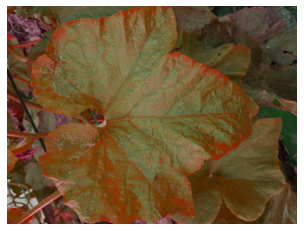

In [52]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_vector)) #랜덤 아이디
image = img_name_vector[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_vector[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0

Real Caption: 잎에 노란색 반점과 분생포자가 발견되어 토마토 잎곰팡이병으로 생각됩니다
Predicted Caption: 잎에 노란색 반점과 분생포자가 발견되어 토마토 잎곰팡이병으로 생각됩니다


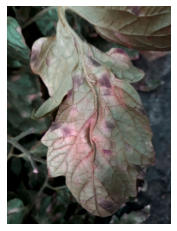

In [61]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 88.88888888888889
BLEU-2 score: 81.6496580927726
BLEU-3 score: 74.86196245806961
BLEU-4 score: 66.06328636027614

Real Caption: 검은 점이 잎에 있는 것으로 보아 콩점무늬병으로 판단됩니다
Predicted Caption: 검은 점이 콩 잎에 있는 것으로 보아 콩점무늬병으로 판단됩니다


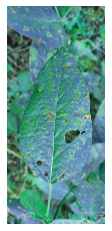

In [63]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 57.14285714285714
BLEU-2 score: 41.93139346887673
BLEU-3 score: 28.168855585454473
BLEU-4 score: 4.249232005220522e-76

Real Caption: 원형 반점과 황갈색 포자덩어리가 나타나고 말라 비틀어진 것을 보아 고추탄저병으로 의심됩니다
Predicted Caption: 고추에 움푹 들어간 원형 반점과 황갈색의 포자덩어리가 나타나며 말라 비틀어진 것으로 보아 고추탄저병으로 의심됩니다


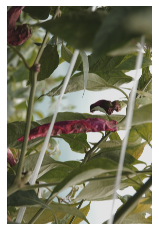

In [74]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 33.453839282436896
BLEU-2 score: 27.702410779900845
BLEU-3 score: 21.061608869051955
BLEU-4 score: 3.004969387521094e-76

Real Caption: 밀가루를 바른 것과 같은 포자와 담황색 병무늬가 나타나는 것으로 보아 애호박 흰가루병으로 의심됩니다
Predicted Caption: 애호박 잎에 담황색 병무늬가 발견되어 애호박 흰가루병으로 의심됩니다


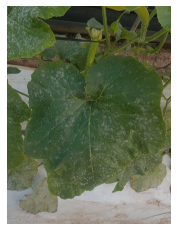

In [75]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

C:\Users\DI Lee\.keras\datasets\image.jpg
Prediction Caption: 애호박 잎에서 특별한 질병이 발견되지 않았기 때문에 정상으로 간주됩니다


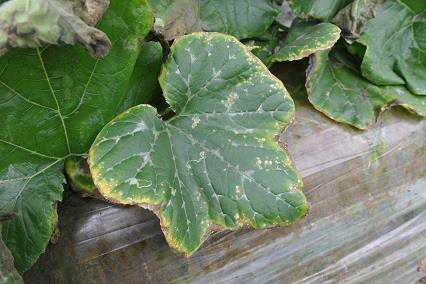

In [78]:
image_url = 'https://www.nongmin.com/upload/bbs/201708/20170801174600019/20170801174600019.jpg'
image_extension = image_url[-4:]
# print(image_extension)
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
print(image_path)
result,_, _ = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
# opening the image
Image.open(image_path)

In [19]:
image_url = 'https://www.nongmin.com/upload/bbs/201708/20170801174600019/20170801174600019.jpg'
image_extension = image_url[-4:]
# print(image_extension)
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
print(image_path)
result,_, _ = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
# opening the image
Image.open(image_path)

C:\Users\DI Lee\.keras\datasets\image.jpg


NameError: name 'evaluate' is not defined